In [1]:
import cv2, os, gc, time
import matplotlib.pyplot as plt
from matplotlib import patches
import pandas as pd
from shapely.geometry import Polygon, MultiPolygon, LineString, MultiLineString
from shapely.ops import transform, split, linemerge, polygonize, unary_union
import numpy as np
from shapely.geometry import MultiPoint, MultiPolygon, Polygon
from shapely import affinity
import plotly.express as px
import numpy as np
import copy
import math
from rectpack import newPacker, PackingBin, GuillotineBafSas, SORT_LSIDE, SORT_AREA, MaxRectsBlsf, SkylineMwfWm

import warnings
warnings.filterwarnings('ignore')

## Class Definitions

In [2]:
class Image:
    '''
    Image object contains information about the current image being processed.
    Initial attributes include ID, matrix, and shape data
    '''
    def __init__(self, ID, matrix):
        self.ID = ID
        self.matrix = matrix
        self.width = matrix.shape[1]
        self.height = matrix.shape[0]
        self.area = matrix.shape[0] * matrix.shape[1]
        self.shape = (matrix.shape[0], matrix.shape[1])
    
    '''
    set label information for image (enables mapping binary value to list of labels)
    matrix is a numpy matrix of binary values indicated classes present in a given pixel
    '''
    def set_label_info(self, label_list, matrix, score_matricies):
        self.label_matrix = matrix
        self.label_lookup = label_list
        self.score_matricies = score_matricies

In [3]:
class Box:
    '''
    Initialization of Box object requires minimum and maximum 
    xy coordinates, a prediction score, and class label. Initial
    attributes of a Box object are:
    
    xmin, ymin, xmax, ymax, score, label, width, height, area
    '''
    def __init__(self, xmin, ymin, xmax, ymax):
        self.xmin, self.ymin = (int(xmin), int(ymin))
        self.xmax, self.ymax = (int(xmax), int(ymax))
        
        self.width = int(xmax) - int(xmin)
        self.height = int(ymax) - int(ymin)
        self.area = (int(xmax) - int(xmin)) * (int(ymax) - int(ymin))
        self.label = ""
        self.score = 0.0
        
        self.aug_width = self.width
        self.aug_height = self.height
    
    '''
    Returns list of box coordinates in clockwise order.
    Can be used to create shapely Polygons
    '''
    def get_coordinate_list(self):
        return [[self.xmin, self.ymin], [self.xmax, self.ymin], 
                [self.xmax, self.ymax], [self.xmin, self.ymax]]
    
    '''
    When performing augmentations to boxes (i.e. scaling), set the new
    coordinates and box info by calling this function.
    '''
    def set_augmented_box(self, w, h):        
        self.aug_width = int(w)
        self.aug_height = int(h)
    
    '''
    Print individual box attributes.
    '''
    def print_box(self, ID):
        print(f"{ID}: ({self.xmin}, {self.ymin}, {self.width}, {self.height}, {self.label}, {self.score})")
        
    def print_box_augmentation(self, ID):
        print(f"{ID}: ({self.width} --> {self.aug_width}, {self.height} --> {self.aug_height})")

In [4]:
'''
Function to print attributes of boxes in a dictionary.

Input: box_dict (dtype = Dict)
Output: None
'''
def print_box_dict(boxes_dict):
    for box_id in boxes_dict: boxes_dict[box_id].print_box(box_id)

def print_box_aug_dict(boxes_dict):
    for box_id in boxes_dict: boxes_dict[box_id].print_box_augmentation(box_id)    

## Pipeline
The following section details step by step the process for obtaining final box regions. Each process is broken down into cells with function definitions and a cell to run the corresponding methods. The end of the section contains a cell to run the entire process at once rather than step by step. 

### Image Selection

In [5]:
# select image and create image object. get corresponding predictions
current_image_id = "779aa089b46c110c.jpg"
current_image = Image(current_image_id, cv2.imread(current_image_id))
df_predictions_image = pd.read_csv("predictions.csv")

In [6]:
df_predictions_image

index                   img  box_x1  box_y1  box_x2  box_y2  \
0   708284  779aa089b46c110c.jpg   441.0   221.0   462.0   246.0   
1   708285  779aa089b46c110c.jpg   708.0   344.0   760.0   365.0   
2   708286  779aa089b46c110c.jpg   946.0   296.0   958.0   310.0   
3   708287  779aa089b46c110c.jpg   822.0   359.0   892.0   389.0   
4   708288  779aa089b46c110c.jpg   748.0   384.0   768.0   407.0   
5   708289  779aa089b46c110c.jpg   387.0   269.0   452.0   277.0   
6   708290  779aa089b46c110c.jpg   958.0   329.0  1014.0   359.0   
7   708291  779aa089b46c110c.jpg   711.0   293.0   962.0   388.0   
8   708292  779aa089b46c110c.jpg   635.0   218.0   661.0   244.0   
9   708293  779aa089b46c110c.jpg   701.0   340.0   874.0   364.0   
10  708294  779aa089b46c110c.jpg   813.0   275.0   833.0   298.0   
11  708295  779aa089b46c110c.jpg   987.0   274.0   997.0   298.0   
12  708296  779aa089b46c110c.jpg   200.0   392.0   225.0   413.0   
13  708297  779aa089b46c110c.jpg   709.0   341.0   895.0   389.0   
14  708298  779aa089b46c110c.jpg    97.0   356.0   620.0   533.0   
15  708299  779aa089b46c110c.jpg   614.0   362.0   939.0   503.0   

            label  score  
0       stop sign   0.01  
1             car   0.01  
2   traffic light   0.01  
3             car   0.01  
4          person   0.01  
5           bench   0.01  
6             car   0.02  
7           truck   0.03  
8     sports ball   0.04  
9             car   0.05  
10      stop sign   0.06  
11  traffic light   0.09  
12         person   0.29  
13            car   0.74  
14            car   0.92  
15            car   0.96

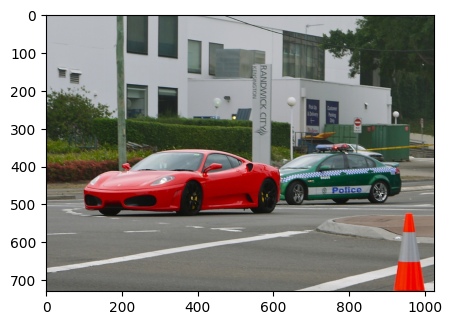

In [7]:
figure, ax = plt.subplots(1, figsize=(5,5))
ax.imshow(current_image.matrix[:,:,::-1])

### General Functions
These function are just for visualization purposes and are not part of the pipeline.

In [8]:
'''
Create boxes to overlay on image via matplotlib.
Output is two lists with first being a list of rectangle patches
and the second being a list of patch labels. Patch labels are in the form 
of a tuple with x coord, y coord, text

Input: boxes (dtype = DataFrame or Dict)
Output: List, List 
'''
def create_overlay_boxes(boxes):
    rect_patches, patch_labels = [], []
    if isinstance(boxes, pd.DataFrame):
        for index, row in boxes.iterrows():
            w, h = row['box_x2'] - row['box_x1'], row['box_y2'] - row['box_y1']
            rect = patches.Rectangle((row['box_x1'], row['box_y1']), w, h, edgecolor='greenyellow', facecolor="none", linewidth = 5)
            rect_patches.append(rect)
            patch_labels.append((row['box_x1'], row['box_y1'], f"{index}: {row['label']} {round(row['score'], 2)}"))
    elif isinstance(boxes, dict):
        for box_id in boxes:
            color = 'r'
            box = boxes[box_id]   
            rect = patches.Rectangle((box.xmin, box.ymin), box.width, box.height, edgecolor='greenyellow', facecolor="none", linewidth = 5)
            rect_patches.append(rect)
            patch_labels.append((box.xmin, box.ymin, f"{box_id}: {box.label} {box.score}"))
    else: assert("invalid input type")
    return rect_patches, patch_labels

In [9]:
'''
Draws grid of specified size on top of image for visualization purposes.
'''
def draw_CTU_blocks(matrix, size):
    w_i = 0
    while w_i < matrix.shape[1]:
        matrix[0:matrix.shape[0], w_i-1:w_i+1] = (255, 255, 255)
        w_i += size
    
    h_i = 0
    while h_i < matrix.shape[0]:
        matrix[h_i-1:h_i+1, 0:matrix.shape[1]] = (255, 255, 255)
        h_i += size
    return matrix

------------------------------------------------------------------------------------------------------------------

### Region Handling

Given a DataFrame of predictions made by a Deep Learning Model (with columns = img, w, h, box_x1, box_y1, box_x2, box_y2, label, score) and a specified image, this section of the program identifies the important regions. Regions are then split up into efficient rectangles and later packed.

Final output for this section is a dictionary of box objects with format {ID: BOX, ID: BOX, ... , ID: BOX}

### Step by Step

#### Prediction Function

In [10]:
'''
Round x and y coordinates in Pandas DataFrame by conversion from float to int.

Input: df (dtype = DataFrame)
Output: DataFrame
'''
def prepare_predictions(df):
    df['box_x1'] = df['box_x1'].astype('int')
    df['box_x2'] = df['box_x2'].astype('int')
    df['box_y1'] = df['box_y1'].astype('int')
    df['box_y2'] = df['box_y2'].astype('int')
    df = df.reset_index(drop=True)
    df['label'] = df['label'].str.replace(' ', '_')
    return df

#### Run Prediction Function

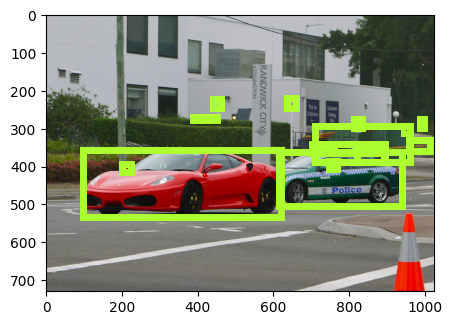

In [11]:
df_predictions_image = prepare_predictions(df_predictions_image)

figure, ax = plt.subplots(1, figsize=(5,5))
ax.imshow(current_image.matrix[:,:,::-1])
display_boxes, display_labels = create_overlay_boxes(df_predictions_image)
for db in display_boxes: ax.add_patch(db)

#### Functions to Create Region Polygon and Label Matricies

In [12]:
'''
Helper function used to convert a given value to a binary number based on lookup table. Binary values
are stored in numpy matrix. This is used to indicate classes present in a given pixel.
Example: lookup = ['background', 'person', 'handbag', 'bench']
A binary value of 0110 indicates that both a person and handbag are present in a given pixel

Input: matrix (dtype = np.array), value (dtype = string), lookup (dtype = list),
xmin, ymin, xmax, ymax (dtype = int)
Output: np.array (matrix)
'''
def set_binary_matrix_slice(matrix, value, lookup, xmin, ymin, xmax, ymax):
    value_index = lookup.index(value)
    binary_list = ['0'] * len(lookup)
    
    binary_list[value_index] = '1'
    binary_string = "".join(binary_list)
    binary_num = int(binary_string, 2)

    matrix[ymin : ymax, xmin : xmax] = np.bitwise_or(matrix[ymin : ymax, xmin : xmax], binary_num)
    return matrix

In [13]:
'''
Helper function used to set matrix values to maximum value. If a matrix value is greater than the input value, 
keep the matrix value, otherwise set the matrix value to the input value. 

Input: matrix (dtype = np.array), value (dtype = float), xmin, ymin, xmax, ymax (dtype = int)
Output: np.array(matrix)
'''
def set_max_matrix_slice(matrix, value, xmin, ymin, xmax, ymax):
    matrix_slice = matrix[ymin : ymax, xmin : xmax]
    matrix_slice[matrix_slice < value] = value
    matrix[ymin : ymax, xmin : xmax] = matrix_slice
    return matrix

In [14]:
'''
Helper function used to pad box coordinates by 15 pixels (within image bounds)

Input: xmin, ymin, xmax, ymax (dtype = int), image (dtype = Image)
Output: int, int, int, int
'''
def pad_box(xmin, ymin, xmax, ymax, image, amount):
    if xmax + amount <= image.width: xmax = xmax + amount
    else: xmax = image.width
    if ymax + amount <= image.height: ymax = ymax + amount
    else: ymax = image.height
    if xmin - amount > 0: xmin = xmin - amount
    else: xmin = 0
    if ymin - amount > 0: ymin = ymin - amount
    else: ymin = 0
    
    return xmin, ymin, xmax, ymax

In [15]:
'''
Create multipolygon box region using shapely library and predictions from deep learning model.
Additionally sets up label information and score information using matricies.

Input: df(dtype = DataFrame), image (dtype = Image)
Output: multipolygon (dtype = Shapely.MultiPolygon), image = (dtype = Image)
'''
def create_box_region_polygon(df, image, padding_amount):
    p = []
    binary_mask = np.zeros(image.shape).astype('int')
    label_matrix = np.zeros(image.shape).astype('int')

    score_matricies = {}
    label_lookup = ['background'] + list(df['label'].unique())
    for label in label_lookup: score_matricies[label] = np.zeros(image.shape).astype('float')
    
    for _, row in df.iterrows():
        xmin, xmax, ymin, ymax = int(row['box_x1']), int(row['box_x2']), int(row['box_y1']), int(row['box_y2'])

        label_matrix = set_binary_matrix_slice(label_matrix, row['label'], label_lookup, xmin, ymin, xmax, ymax)
        score_matricies[row['label']] = set_max_matrix_slice(score_matricies[row['label']], row['score'], xmin, ymin, xmax, ymax)
        
        xmin, ymin, xmax, ymax = pad_box(xmin, ymin, xmax, ymax, image, padding_amount)
        rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, edgecolor='greenyellow', facecolor="none", linewidth = 5)
        p.append(rect)
        binary_mask[ymin : ymax, xmin : xmax] = 1
    
    image.set_label_info(label_lookup, label_matrix, score_matricies)
    
    contour, hier = cv2.findContours(binary_mask,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)
    
    remove = []
    for i, c in enumerate(contour):
        if len(c) < 4: remove.append(i)
    if len(remove) != 0: contour = np.delete(contour, remove)
        
    contours = map(np.squeeze, contour)
    polygons = map(Polygon, contours)
    multipolygon = MultiPolygon(polygons)
    
    return multipolygon, image

#### Run Functions to Create Region Polygon and Label Matricies

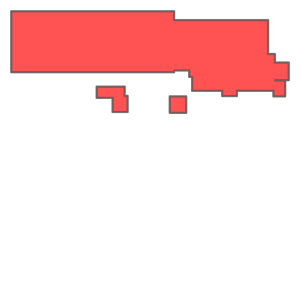

In [16]:
region_polygon, current_image = create_box_region_polygon(df_predictions_image, current_image, 15)
region_polygon

In [17]:
current_image.label_lookup

['background',
 'stop_sign',
 'car',
 'traffic_light',
 'person',
 'bench',
 'truck',
 'sports_ball']

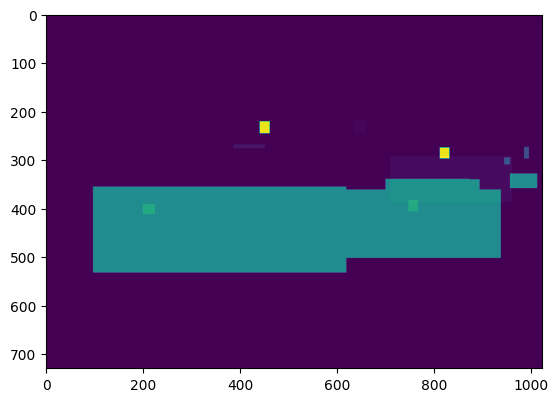

In [18]:
plt.imshow(current_image.label_matrix)

#### Functions to Create MultiPolygon Grid and Merge Grid Region

In [19]:
'''
Functions to divide/pad multipolygon box region into squares of specified grid size

Input: multipolygon (dtype = Shapely.MultiPolygon), square_size (dtype = int)
Output: Shapely.MultiPolygon
'''
def create_square(x, y, s):
    return Polygon([(x, y), (x+s, y), (x+s, y+s), (x, y+s)])

def divide_box_region_with_grid(multipolygon, square_size):
    square_bounds = np.array(multipolygon.bounds)//square_size
    square_bounds[2:4] += 1
    xmin, ymin, xmax, ymax = square_bounds*square_size
    x_coords = np.arange(xmin, xmax, square_size)
    y_coords = np.arange(ymin, ymax, square_size)
    grid_polygons = MultiPolygon([create_square(x, y, square_size) for x in x_coords for y in y_coords])
    grid_polygons = MultiPolygon(list(filter(multipolygon.intersects, grid_polygons)))

    return grid_polygons

In [20]:
'''
Functions to merge the grid region into one or more polygons. Final output is a list of tuples with first 
element being the polygon and second element being the corresponding coordinates.

Input: grid_polygons (dtype = Shapely.MultiPolygon)
Output: List of tuples
'''
def rotate_coords(l, n):
    return l[-n:] + l[:-n]

def combine_grid_region(grid_polygons):
    final_polygon = unary_union(grid_polygons.geoms)
    if str(type(final_polygon)) != "<class 'shapely.geometry.multipolygon.MultiPolygon'>": 
        final_polygon = [final_polygon]
    
    final_poly_reduced_coords = []
    for poly in final_polygon:
        coords = (list(poly.exterior.coords))
        while (coords[0][0] == coords[-1][0]): coords = rotate_coords(coords, 1)
        reduced_coords = np.array(coords + [coords[0]])
        
        x_coords = reduced_coords[:,0]
        reduced_coords = np.vstack([(x[0], x[-1]) if len(x) > 1 else x[0] for x in np.split(reduced_coords, [i+1 for i, (x1, x2) in enumerate(zip(x_coords, x_coords[1:])) if x1 != x2])])
        y_coords = reduced_coords[:,1]
        reduced_coords = np.vstack([(y[0], y[-1]) if len(y) > 1 else y[0] for y in np.split(reduced_coords, [i+1 for i, (y1, y2) in enumerate(zip(y_coords, y_coords[1:])) if y1 != y2])])
        
        final_poly_reduced_coords.append((Polygon(reduced_coords), reduced_coords))
        
    return final_poly_reduced_coords

#### Run Functions to Create MultiPolygon Grid and Merge Grid Region

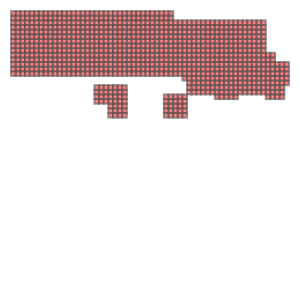

In [21]:
region_grid_polygons = divide_box_region_with_grid(region_polygon, 16)
region_grid_polygons

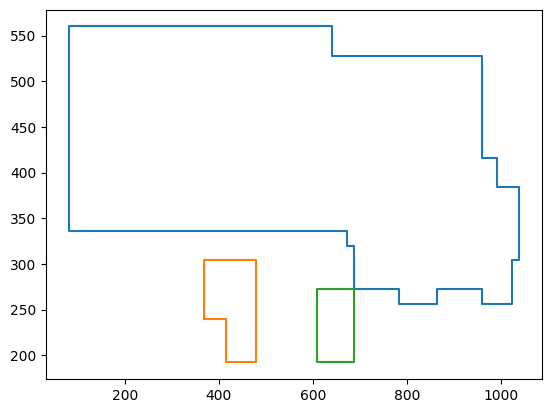

In [22]:
merged_grid_polygon = combine_grid_region(region_grid_polygons)
for region in merged_grid_polygon:
    plt.plot(*region[0].exterior.xy)

#### Functions to Split Region at Verticies and Create Box Objects

In [23]:
'''
Cut the polygon at verticies that are not aligned with polygon bounds. Creates new split MultiPolygon.

Input: polygon (dtype = Shapely.Polygon), poly_coords(dtype = np.array)
Output: Shapely.MultiPolygon
'''
def cut_polygon_at_verticies(polygon, poly_coords):
    x_lower = min(polygon.bounds[0], polygon.bounds[2])
    x_upper = max(polygon.bounds[0], polygon.bounds[2])
    y_lower = min(polygon.bounds[1], polygon.bounds[3])
    y_upper = max(polygon.bounds[1], polygon.bounds[3])
    lines = []
    for coords in poly_coords:
        x_line = LineString([(coords[0],y_lower), (coords[0],y_upper)])
        y_line = LineString([(x_lower,coords[1]), (x_upper,coords[1])])

        lines.append(x_line)
        lines.append(y_line)
    split_polygons = polygonize(polygon.intersection(MultiLineString(lines)))
    split_polygons = MultiPolygon(split_polygons)
    
    return split_polygons

In [24]:
'''
Returns valid coordinates of polygon. If any of the grid regions exceed image bound (which can occur after
applying grid padding), clip the coordinates to be at image bound. Input is list of x coords, list of y coords,
and image object.

Input: xs (dtype = List), ys (dtype = List)
Output: xmin, ymin, xmax, ymax (dtype = int)
'''
def get_valid_coordinates(xs, ys, image):
    if min(xs) < 0: xmin = 0
    else: xmin = min(xs)
    if min(xs) > image.width: xmin = image.width
    if max(xs) > image.width: xmax = image.width
    else: xmax = max(xs)

    if min(ys) < 0: ymin = 0
    else: ymin = min(ys)
    if min(ys) > image.height: ymin = image.height
    if max(ys) > image.height: ymax = image.height
    else: ymax = max(ys)
    
    return int(xmin), int(ymin), int(xmax), int(ymax)

In [25]:
'''
Creates list of box objects from split polygons. Assigned scores to each box based on the maximum score
present in that region. 

Input: polygons (dtype = Shapely.MultiPolygon), image (dtype = Image)
Output: List of box objects
'''
def create_box_objects(polygons, image):
    box_indicies = sorted([(i, b.area) for i, b in enumerate(polygons)], key=lambda x: -x[1])
    
    box_objects = []
    for position, _ in box_indicies:
        xmin, ymin, xmax, ymax = get_valid_coordinates(polygons[position].exterior.xy[0], polygons[position].exterior.xy[1], image)
        
        if xmax - xmin != 0.0 and ymax - ymin != 0.0: #if the box has width and height
            new_box = Box(xmin, ymin, xmax, ymax)
            box_objects.append(new_box)

    return box_objects

In [26]:
'''
Recursively reattaches new_box if it shares an edge with an existing box. Merge boxes that share an edge.

Input: boxes (dtype = List), image (dtype = Image)
Output: List of box objects, Box objects
'''
def process_reattach(boxes, new_box):
    for existing_box in boxes: #check existing dictionary elements
        share_edge = False

        if (existing_box.xmin, existing_box.ymin, existing_box.xmax, existing_box.ymin) == (new_box.xmin, new_box.ymax, new_box.xmax, new_box.ymax): share_edge = True
        elif (new_box.xmin, new_box.ymin, new_box.xmax, new_box.ymin) == (existing_box.xmin, existing_box.ymax, existing_box.xmax, existing_box.ymax): share_edge = True
        elif (existing_box.xmin, existing_box.ymin, existing_box.xmin, existing_box.ymax) == (new_box.xmax, new_box.ymin, new_box.xmax, new_box.ymax): share_edge = True
        elif (new_box.xmin, new_box.ymin, new_box.xmin, new_box.ymax) == (existing_box.xmax, existing_box.ymin, existing_box.xmax, existing_box.ymax): share_edge = True
            
        if share_edge:
            xmin, ymin = (min(new_box.xmin, existing_box.xmin), min(new_box.ymin, existing_box.ymin))
            xmax, ymax = (max(new_box.xmax, existing_box.xmax), max(new_box.ymax, existing_box.ymax))

            #check to see if the merge captured any of the existing boxes,
            boxes.remove(existing_box)
            boxes, new_box = process_reattach(boxes, Box(xmin, ymin, xmax, ymax))
            return boxes, new_box
    return boxes, new_box

In [27]:
'''
Reattach boxes that share an edge. A somewhat greedy approach with tries to reattach boxes with higher scores
first. Returns list of box objects.

Input: boxes (dtype = List of Box Objects
Output: List of Box Objects
'''
def reattach_shared_edges(boxes):
    final_boxes = []
    new_box_id = 0 #variable to track index of new boxes
    for new_box in boxes:
        final_boxes, new_box = process_reattach(final_boxes, new_box)
        final_boxes.append(new_box)

    return final_boxes

In [28]:
'''
Helper function to obtain box label for a region. Examines the unique labels present in the region and looks 
at how many pixels make up each label. Sort labels by area in region and preserve labels before the largest drop
in area. 

Input: box (dtype = Box), image (dtype = Image)
Output: List
'''
def get_box_labels(box, image):
    labels, counts = np.unique(image.label_matrix[box.ymin : box.ymax, box.xmin : box.xmax], return_counts=True)
    labels = np.column_stack((labels, counts)) 
    labels = labels[labels[:, 0] != 0]
    labels = sorted(labels, key=lambda k: -k[1])
    
    final_labels = []
    unique_labels = []
    for label in labels:
        binary_num = bin(label[0])
        binary_list = [int(x) for x in binary_num[2:]]

        if len(binary_list) < len(image.label_lookup):
            pad = [0] * (len(image.label_lookup) - len(binary_list))
            binary_list = pad + binary_list

        for index, bit in enumerate(binary_list):
            if bit: 
                l = image.label_lookup[index]
                s = 100 * np.mean(image.score_matricies[l][box.ymin : box.ymax, box.xmin : box.xmax][image.score_matricies[l][box.ymin : box.ymax, box.xmin : box.xmax] > 0])
                relative_size = label[1]/box.area
                if not l in unique_labels: 
                    final_labels.append((l, relative_size*s, s))
                    unique_labels.append(l)
    
    final_labels = sorted(final_labels, key=lambda k: -k[1])

    if len(final_labels) > 1:
        diff = [abs(final_labels[i][1] - final_labels[i+1][1]) for i in range(len(final_labels)-1)]
        final_labels = final_labels[0:np.argmax(diff)+1]
    
    if len(final_labels) > 0:
        labels, metrics, scores = zip(*final_labels)
    else: labels, scores = [], []
    return labels, scores

#### Run Functions to Split Region at Verticies and Create Box Objects

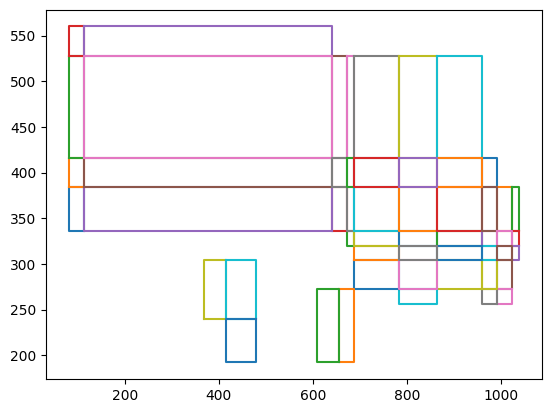

In [29]:
regions_dict = {}
new_box_index = 0
for region_poly, coords in merged_grid_polygon:
    split_region_polygons = cut_polygon_at_verticies(region_poly, coords)
    for sp in split_region_polygons:
        plt.plot(*sp.exterior.xy)
    
    split_boxes = create_box_objects(split_region_polygons, current_image)
    reattached_region_boxes = reattach_shared_edges(split_boxes)
    
    # use reattached box regions to create final boxes with labels and scores
    for i, rb in enumerate(reattached_region_boxes):
        labels, scores = get_box_labels(rb, current_image)
        #print(labels)
        rb.label = labels
        rb.score = scores
                    
        regions_dict[new_box_index] = rb
        new_box_index += 1

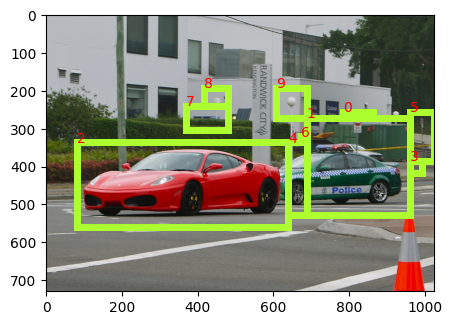

In [30]:
figure, ax = plt.subplots(1, figsize=(5,5))

ax.imshow(current_image.matrix[:,:,::-1])
display_boxes, display_labels = create_overlay_boxes(regions_dict)
for db in display_boxes: ax.add_patch(db) 
for dl in display_labels: ax.text(dl[0], dl[1], dl[2].split(":")[0], color="red")

In [31]:
print_box_dict(regions_dict)

0: (784, 256, 80, 16, [], [])
1: (688, 272, 272, 256, ('car',), (92.9116076376644,))
2: (80, 336, 560, 224, ('car',), (92.15372519420073,))
3: (960, 384, 32, 32, ('truck',), (3.0,))
4: (640, 336, 48, 192, ('car',), (96.00000000000004,))
5: (960, 256, 64, 128, ('car', 'traffic_light'), (1.9999999999999993, 9.000000000000002))
6: (672, 320, 16, 16, [], [])
7: (368, 240, 112, 64, ('bench',), (0.9999999999999999,))
8: (416, 192, 64, 48, ('stop_sign',), (0.9999999999999999,))
9: (608, 192, 80, 80, ('sports_ball',), (3.9999999999999996,))


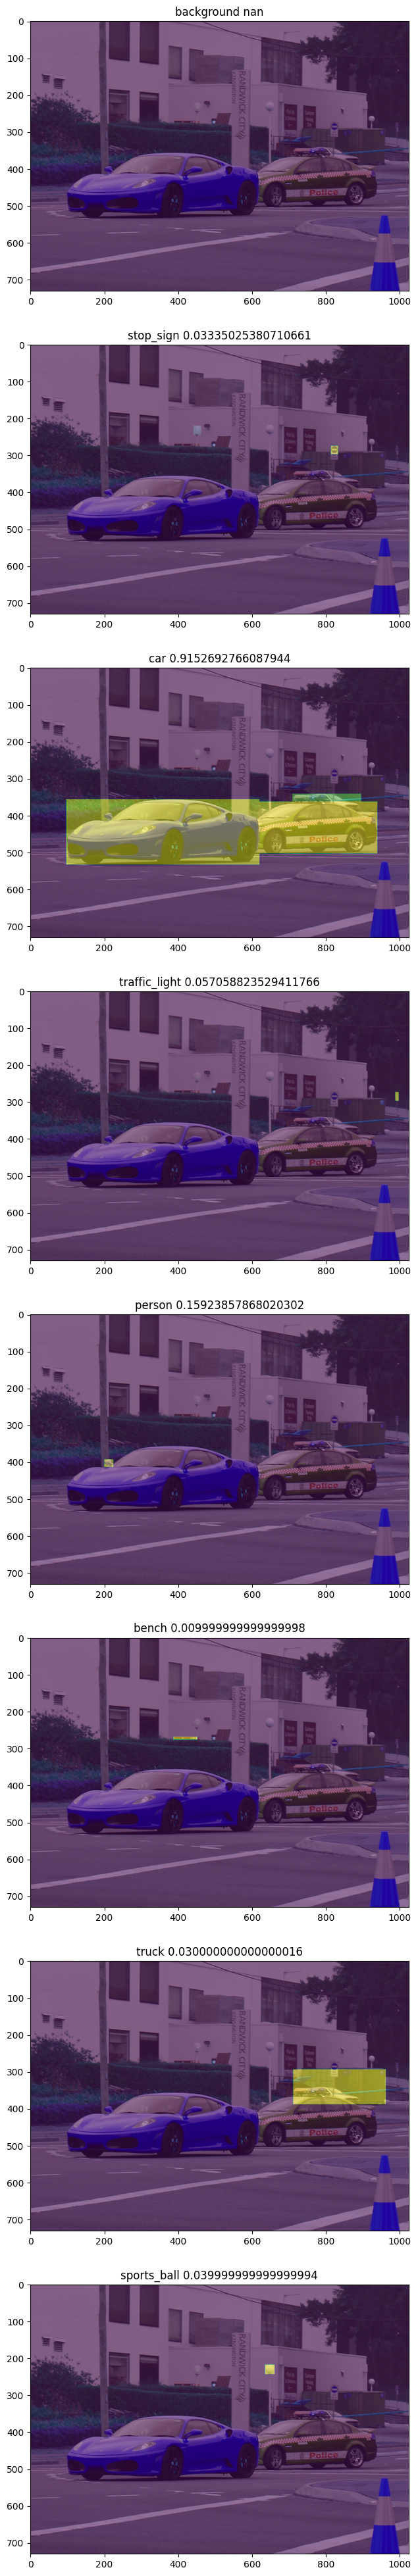

In [32]:
fig, ax = plt.subplots(len(current_image.score_matricies), figsize=(25,50))
for i, label in enumerate(current_image.score_matricies):
    ax[i].imshow(current_image.matrix)
    ax[i].imshow(current_image.score_matricies[label], alpha=0.5)
    ax[i].set_title(label+" "+str(np.mean(current_image.score_matricies[label][current_image.score_matricies[label] > 0])))

#### Functions to Perform Scaling

In [33]:
def OID_class_based_scaling(boxes_dict, size):
    sensitive_classes = ['apple',  'orange',  'traffic_light',  'laptop',  'horse',  'car',  'zebra',  'person',  'sheep',  'cow',  'sports_ball',  'broccoli',  'airplane',  'book',  'spoon',  'vase',  'boat',  'carrot',  'skateboard',  'surfboard',  'bottle',  'donut',  'knife',  'suitcase',  'clock',  'backpack',  'tennis_racket',  'giraffe',  'couch',  'toilet',  'bus']
    highly_sensitive_classes = ['handbag']
    
    for box_id in boxes_dict:
        b = boxes_dict[box_id]
        
        if not set(b.label).isdisjoint(set(highly_sensitive_classes)): factor = 0
        elif set(b.label).isdisjoint(set(sensitive_classes)): factor = 50
        else: factor = 30

        scale = factor * (size/100)
            
        print(f"{b.label} permits {scale}% scaling based on size {size}")
        
        w_, h_ = math.ceil(boxes_dict[box_id].width * (100-scale)/100), math.ceil(boxes_dict[box_id].height * (100-scale)/100)
        boxes_dict[box_id].set_augmented_box(w_, h_)
    return boxes_dict

#### Run Functions to Perform Scaling

In [34]:
regions_dict = OID_class_based_scaling(regions_dict, 100)
print_box_aug_dict(regions_dict)

[] permits 50.0% scaling based on size 100
('car',) permits 30.0% scaling based on size 100
('car',) permits 30.0% scaling based on size 100
('truck',) permits 50.0% scaling based on size 100
('car',) permits 30.0% scaling based on size 100
('car', 'traffic_light') permits 30.0% scaling based on size 100
[] permits 50.0% scaling based on size 100
('bench',) permits 50.0% scaling based on size 100
('stop_sign',) permits 50.0% scaling based on size 100
('sports_ball',) permits 30.0% scaling based on size 100
0: (80 --> 40, 16 --> 8)
1: (272 --> 191, 256 --> 180)
2: (560 --> 392, 224 --> 157)
3: (32 --> 16, 32 --> 16)
4: (48 --> 34, 192 --> 135)
5: (64 --> 45, 128 --> 90)
6: (16 --> 8, 16 --> 8)
7: (112 --> 56, 64 --> 32)
8: (64 --> 32, 48 --> 24)
9: (80 --> 56, 80 --> 56)


#### Functions to Perform CTU Alignment

In [35]:
def closest_factor(x, n): #example: n = 16
    z = max(x - (x % n), n)
    return z

In [36]:
def CTU_scale(boxes_dict, factor):
    for box_id in boxes_dict:
        w, h = boxes_dict[box_id].aug_width, boxes_dict[box_id].aug_height
        
        long = max(w,h)
        short = min(w,h)
        
        short_ctu = closest_factor(short, factor)
        long_ctu = math.floor(long * (short_ctu / short))
        long_ctu = closest_factor(long_ctu, factor)
        
        if h == long: w_, h_ = (short_ctu, long_ctu)
        else: w_, h_ = (long_ctu, short_ctu)
        
        boxes_dict[box_id].set_augmented_box(w_, h_)
        
    return boxes_dict

In [37]:
regions_dict = CTU_scale(regions_dict, 16)

In [38]:
print_box_aug_dict(regions_dict)

0: (80 --> 80, 16 --> 16)
1: (272 --> 176, 256 --> 176)
2: (560 --> 352, 224 --> 144)
3: (32 --> 16, 32 --> 16)
4: (48 --> 32, 192 --> 112)
5: (64 --> 32, 128 --> 64)
6: (16 --> 16, 16 --> 16)
7: (112 --> 48, 64 --> 32)
8: (64 --> 16, 48 --> 16)
9: (80 --> 48, 80 --> 48)


------------------------------------------------------------------------------------------------------------------

### Run Full Processing
Skip if already run step-by-step

In [39]:
start = time.time()

df_predictions_image = prepare_predictions(df_predictions_image)
region_polygon, current_image = create_box_region_polygon(df_predictions_image, current_image, 15)
region_grid_polygons = divide_box_region_with_grid(region_polygon, 16)
merged_grid_polygon = combine_grid_region(region_grid_polygons)

regions_dict = {}
new_box_index = 0
for region_poly, coords in merged_grid_polygon:
    split_region_polygons = cut_polygon_at_verticies(region_poly, coords)
    split_boxes = create_box_objects(split_region_polygons, current_image)
    reattached_region_boxes = reattach_shared_edges(split_boxes)
    
    for i, rb in enumerate(reattached_region_boxes):
        labels, scores = get_box_labels(rb, current_image)
        rb.label = labels
        rb.score = scores
        
        regions_dict[new_box_index] = rb
        new_box_index += 1

regions_dict = OID_class_based_scaling(regions_dict, 100)
regions_dict = CTU_scale(regions_dict, 16)

end = time.time()
print(end - start)

[] permits 50.0% scaling based on size 100
('car',) permits 30.0% scaling based on size 100
('car',) permits 30.0% scaling based on size 100
('truck',) permits 50.0% scaling based on size 100
('car',) permits 30.0% scaling based on size 100
('car', 'traffic_light') permits 30.0% scaling based on size 100
[] permits 50.0% scaling based on size 100
('bench',) permits 50.0% scaling based on size 100
('stop_sign',) permits 50.0% scaling based on size 100
('sports_ball',) permits 30.0% scaling based on size 100
0.2921156883239746


In [40]:
print_box_dict(regions_dict)

0: (784, 256, 80, 16, [], [])
1: (688, 272, 272, 256, ('car',), (92.9116076376644,))
2: (80, 336, 560, 224, ('car',), (92.15372519420073,))
3: (960, 384, 32, 32, ('truck',), (3.0,))
4: (640, 336, 48, 192, ('car',), (96.00000000000004,))
5: (960, 256, 64, 128, ('car', 'traffic_light'), (1.9999999999999993, 9.000000000000002))
6: (672, 320, 16, 16, [], [])
7: (368, 240, 112, 64, ('bench',), (0.9999999999999999,))
8: (416, 192, 64, 48, ('stop_sign',), (0.9999999999999999,))
9: (608, 192, 80, 80, ('sports_ball',), (3.9999999999999996,))


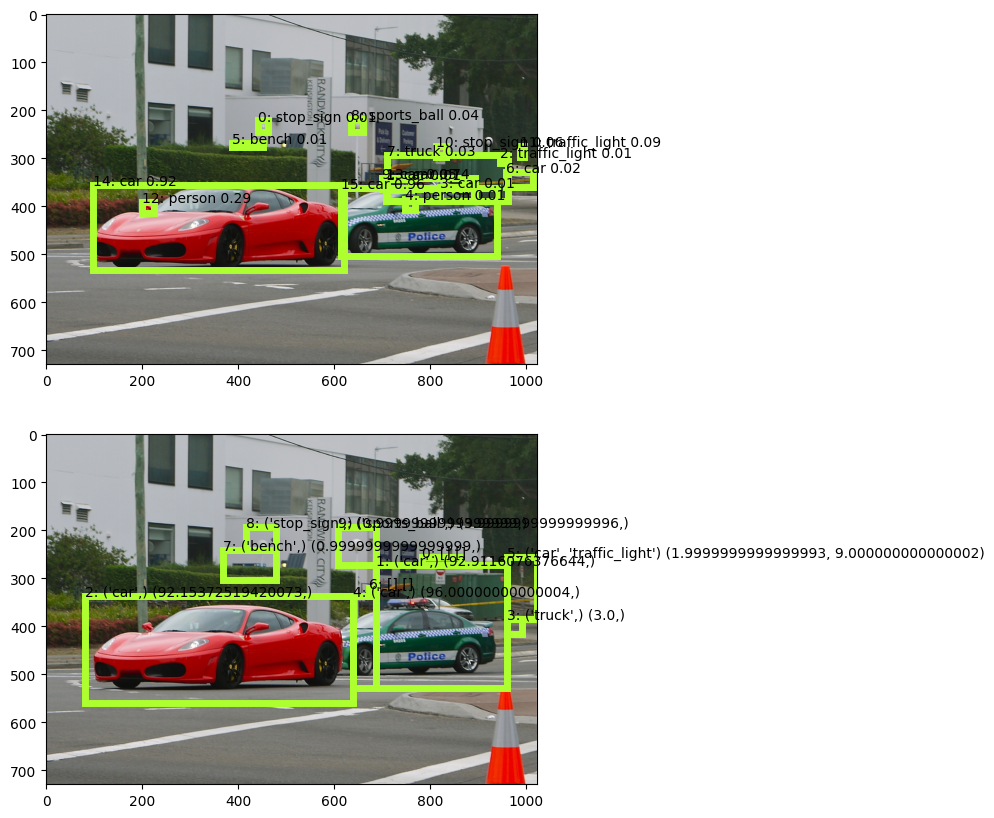

In [41]:
figure, ax = plt.subplots(2, figsize=(7,10))

ax[0].imshow(current_image.matrix[:,:,::-1])
display_boxes, display_labels = create_overlay_boxes(df_predictions_image)
for db in display_boxes: ax[0].add_patch(db)
for dl in display_labels: ax[0].text(dl[0], dl[1], dl[2])
    
ax[1].imshow(current_image.matrix[:,:,::-1])
display_boxes, display_labels = create_overlay_boxes(regions_dict)
for db in display_boxes: ax[1].add_patch(db)
for dl in display_labels: ax[1].text(dl[0], dl[1], dl[2])

------------------------------------------------------------------------------------------------------------------

### Packing
Given a dictionary of boxes and a corresponding image object, pack the boxes using the RectPack Python library. Additionally, create a csv file that can be used unpack the boxes after compression.
https://github.com/secnot/rectpack

#### Packing Functions

In [42]:
'''
Helper function to format box data to be accepted by the Packer. Format is a list of tuples with
the following values (width, height, box id)

Intput: boxes_dict (dtype = Dict)
Output: List
'''
def prepare_for_packing(boxes_dict):
    dims = []
    for box_id in boxes_dict: dims.append((int(boxes_dict[box_id].aug_width),int(boxes_dict[box_id].aug_height), box_id))
    return dims

In [43]:
'''
Function to run the packing algorithm and obtain results. Output is a dictionary of new positions where
each key is a box id and each value a tuple with xmin, ymin, width, and height. The function also outputs 
the dimensions of the packed image (sum of widths and sum of heights of boxes). 

Input: boxes_dict (dtype = Dict)
Output: Dict, int, int
'''
def run_packer(boxes_dict):
    dims = prepare_for_packing(boxes_dict)
    #print(dims)
    
    side, long = 0, 0
    for r in dims:
        side+=r[0]
        long+=r[1]
        
    bins = [(side*10, long*10)]
    packer = newPacker(sort_algo=SORT_LSIDE, bin_algo=PackingBin.BFF,pack_algo=GuillotineBafSas, rotation=False)
    for r in dims: packer.add_rect(*r)
    for b in bins: packer.add_bin(*b)
    packer.pack()
    
    positions_dict = {}
    for abin in packer:
        for rect in abin:
            positions_dict[rect.rid] = (int(rect.x), int(rect.y), int(rect.width), int(rect.height))

    return positions_dict, side, long

In [44]:
'''
Function to create a packed image by calling the packer algorithm. Uses the output positions of 
run_packer to place boxes according to their packed positions. Additionally maintains DataFrame of 
positions used for unpacking. Uses image object to cut out original pixel values to be placed in the new
image. 

Input: boxes_dict (dtype = Dict), image (dtype = Image Object), df_output_positions (dtype = DataFrame)
Output: matrix, DataFrame
'''
def pack_image(boxes_dict, image): 
    positions_dict, side, long = run_packer(boxes_dict)
    
    packed_img = np.zeros((long, side, 3))
    
    packed_width = -1 #bottom right corner x coordinate
    packed_height = -1 #bottom left corner y coordinate

    total_area = 0
    num_objects = 0
    parameters = f"frame_num,num_objects,{image.width},{image.height},"
    for box_id in positions_dict: 
        gc.collect()
        
        #get original box coordinates
        b_x, b_y = boxes_dict[box_id].xmin, boxes_dict[box_id].ymin
        b_w, b_h = boxes_dict[box_id].width, boxes_dict[box_id].height
        
        original_box = image.matrix[b_y:b_y+b_h, b_x:b_x+b_w] #get original box pixel values from image
        
        augmented_box = cv2.resize(original_box, (boxes_dict[box_id].aug_width, boxes_dict[box_id].aug_height)) 

        #get packed box coordinates
        p = positions_dict[box_id]
        p_x, p_y = p[0], p[1]
        p_w, p_h = p[2], p[3]
        
        if (p_x + p_w) > packed_width: packed_width = p_x + p_w   
        if (p_y + p_h) > packed_height: packed_height = p_y + p_h
            
        packed_img[p_y : p_y + p_h, p_x : p_x + p_w] = augmented_box #place original box pixels into packed position
        
        total_area += augmented_box.shape[1] * augmented_box.shape[0]
        parameters += f"{b_x},{b_y},{b_w},{b_h},{p_x},{p_y},{p_w},{p_h},"
        num_objects += 1
    
    parameters = parameters.replace("num_objects", str(num_objects))
    parameters = parameters[0:-1] + "\n"
    crop_packed = packed_img[0 : packed_height, 0 : packed_width] #crop the packed image
        
    return crop_packed.astype('uint8'), parameters, total_area

#### Run Packing

In [45]:
image_packed, packed_parameters, packed_pixels = pack_image(regions_dict, current_image)

In [46]:
packed_parameters

'frame_num,10,1024,730,80,336,560,224,0,0,352,144,688,272,272,256,0,144,176,176,640,336,48,192,176,144,32,112,784,256,80,16,208,144,80,16,960,256,64,128,176,256,32,64,608,192,80,80,208,160,48,48,368,240,112,64,256,160,48,32,960,384,32,32,256,192,16,16,672,320,16,16,272,192,16,16,416,192,64,48,288,192,16,16\n'

In [47]:
image_packed_ctu = draw_CTU_blocks(image_packed.copy(), 16)

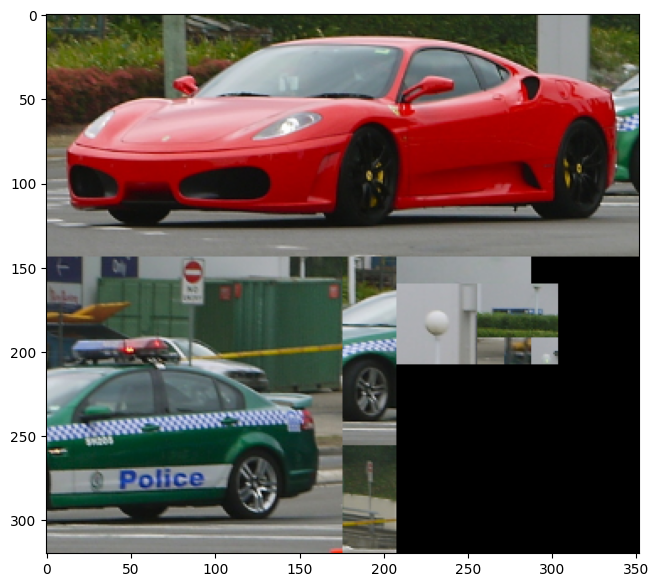

In [48]:
figure, ax = plt.subplots(1, figsize=(10,7))
ax.imshow(image_packed[:,:,::-1])

In [49]:
current_image.area

747520

In [50]:
packed_pixels

93184

In [51]:
image_packed.shape[0] * image_packed.shape[1]

112640

In [52]:
image_packed.shape[1], image_packed.shape[0]  

(352, 320)

In [53]:
current_image.shape[1], current_image.shape[0]  

(1024, 730)

In [54]:
current_image.width, current_image.height

(1024, 730)

------------------------------------------------------------------------------------------------------------------

### Unpacking
Given a csv file with packed image information, unpack the boxes and apply resizing to place objects back into their original positions.

In [55]:
'''
Function to unpack image using the packed image matrix and corresponding dataframe with packed information

Input: packed_matrix (dtype = matrix), df_packed_image_info (dtype = DataFrame)
Output: matrix
'''
def unpack_image(packed_matrix, parameters):
    parameters = parameters.split(",")
    parameters = [parameters[0]] + [ int(x) for x in parameters[1::] ]
    
    original_image_width = parameters[2]
    original_image_height = parameters[3]
    
    unpacked_image = np.zeros((original_image_height, original_image_width, 3))
    binary_matrix = np.zeros((original_image_height, original_image_width)).astype('int')
    
    unpacked_image[unpacked_image == 0] = -1
    
    R = []
    G = []
    B = []
    
    num_objects = parameters[1]
    index = 4
    for i in range(num_objects):
        p_x = parameters[index+4]
        p_y = parameters[index+5]
        p_w = parameters[index+6]
        p_h = parameters[index+7]
        
        packed_box = packed_matrix[p_y : p_y + p_h, p_x : p_x + p_w]

        b_x = parameters[index]
        b_y = parameters[index+1]
        b_w = parameters[index+2]
        b_h = parameters[index+3]
        
        print(f"{b_x},{b_y},{b_w},{b_h},{p_x},{p_y},{p_w},{p_h}")
        packed_box = cv2.resize(packed_box, (b_w, b_h), interpolation=cv2.INTER_CUBIC)
        
        unpacked_image[b_y:b_y+b_h, b_x:b_x+b_w] = packed_box
        
        R.append(np.mean(packed_box[:,:,2]))
        G.append(np.mean(packed_box[:,:,1]))
        B.append(np.mean(packed_box[:,:,0]))
        
        index+=8
    
    unpacked_image[:,:,0][unpacked_image[:,:,0] == -1] = 0
    unpacked_image[:,:,1][unpacked_image[:,:,1] == -1] = 0
    unpacked_image[:,:,2][unpacked_image[:,:,2] == -1] = 0
        
    return unpacked_image.astype('uint8')

In [56]:
packed_parameters

'frame_num,10,1024,730,80,336,560,224,0,0,352,144,688,272,272,256,0,144,176,176,640,336,48,192,176,144,32,112,784,256,80,16,208,144,80,16,960,256,64,128,176,256,32,64,608,192,80,80,208,160,48,48,368,240,112,64,256,160,48,32,960,384,32,32,256,192,16,16,672,320,16,16,272,192,16,16,416,192,64,48,288,192,16,16\n'

In [57]:
start_time = time.time()
image_unpacked = unpack_image(image_packed, packed_parameters)
print(time.time() - start_time)

80,336,560,224,0,0,352,144
688,272,272,256,0,144,176,176
640,336,48,192,176,144,32,112
784,256,80,16,208,144,80,16
960,256,64,128,176,256,32,64
608,192,80,80,208,160,48,48
368,240,112,64,256,160,48,32
960,384,32,32,256,192,16,16
672,320,16,16,272,192,16,16
416,192,64,48,288,192,16,16
0.02670145034790039


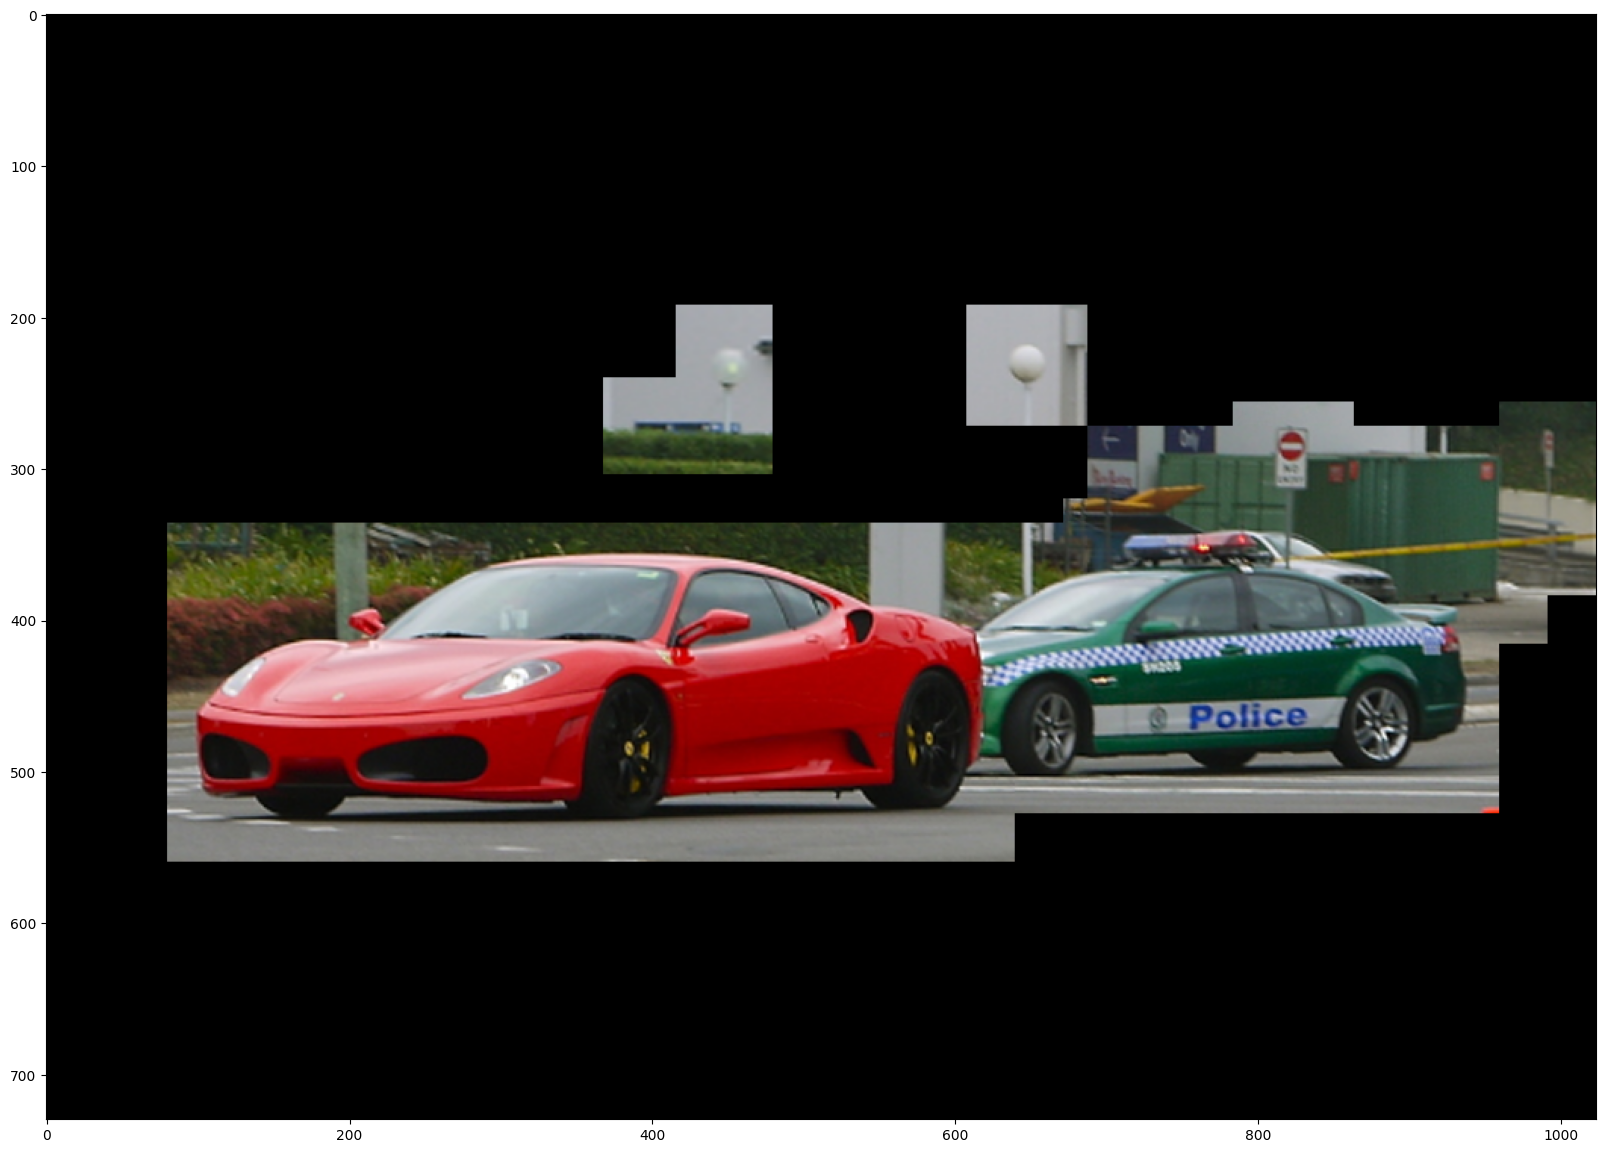

In [58]:
figure, ax = plt.subplots(1, figsize=(20,15))
ax.imshow(image_unpacked[:,:,::-1])